In [52]:
import pandas as pd
import numpy as np
import re

def build_flat_columns(df_raw):
    """
    엑셀 첫 4행(블록명, 컬럼명, 단위)을 이용해 flat column name을 만든다.
    예: 전구체_Ni, 도핑_d1, 1차_T1, 결과_방전용량 ...
    """
    # 1행: 블록명 (전구체, 도핑, 1차, 2차, 3차, 결과...)
    block_row = df_raw.iloc[1].copy()
    block_row = block_row.ffill()  # NaN 부분은 왼쪽 값으로 채움

    # 2행: 컬럼명 (Ni, Co, Mn, d1, d2, d3, Li/M, T1, t1, T2, t2, T3, t3, 방전용량, 유지율)
    name_row = df_raw.iloc[2]

    flat_cols = []
    for i, (block, name) in enumerate(zip(block_row, name_row)):
        if pd.isna(name):
            flat_cols.append(f"col_{i}")
        elif pd.isna(block):
            flat_cols.append(str(name))
        else:
            flat_cols.append(f"{block}_{name}")
    return flat_cols


def parse_doping_value(x):
    """
    'Sr 0.043', 'Al0.01', '0.004' 같은 도핑 값을
    (원소, 수치) 형태로 파싱.
    """
    if pd.isna(x):
        return (np.nan, np.nan)
    s = str(x).strip()

    # 순수 숫자인 경우: 원소 없이 값만
    if re.fullmatch(r"[0-9.]+", s):
        try:
            return (np.nan, float(s))
        except ValueError:
            return (np.nan, np.nan)

    # 'Sr 0.043', 'Al0.01' 형태
    m = re.match(r"([A-Za-z]+)\s*([0-9.]+)?", s)
    if m:
        elem = m.group(1)
        val = m.group(2)
        if val is None:
            return (elem, np.nan)
        try:
            return (elem, float(val))
        except ValueError:
            return (elem, np.nan)

    return (np.nan, np.nan)


def add_doping_columns(df, raw_cols):
    """
    도핑 관련 컬럼(d1, d2, d3 등)을 elem/mol로 분리.
    raw_cols: ['도핑_d1','도핑_d2','도핑_d3'] 이런 리스트
    """
    element_cols = []
    value_cols = []
    for col in raw_cols:
        elems, vals = zip(*df[col].map(parse_doping_value))
        elem_col = col + "_elem"
        val_col = col + "_mol"
        df[elem_col] = elems
        df[val_col] = vals
        element_cols.append(elem_col)
        value_cols.append(val_col)
    # raw 도핑 컬럼 제거
    df = df.drop(columns=raw_cols)
    return df, element_cols, value_cols


def add_two_stage_temp_cols(df, raw_col, prefix=None):
    """
    '750\n700', '720/700', '750' 같은 온도 컬럼을
    high / low 두 개의 숫자 컬럼으로 분리.
    prefix가 있으면 prefix_high / prefix_low로 생성.
    """

    col = df[raw_col]
    high_vals = []
    low_vals = []

    for x in col:
        if pd.isna(x):
            high_vals.append(np.nan)
            low_vals.append(np.nan)
            continue

        s = str(x).strip()
        # 줄바꿈, /, 공백 등으로 구분
        parts = re.split(r"[/\n, ]+", s)
        parts = [p for p in parts if p != ""]

        if len(parts) == 0:
            high_vals.append(np.nan)
            low_vals.append(np.nan)
        elif len(parts) == 1:
            # 단일 온도값
            try:
                high_vals.append(float(parts[0]))
                low_vals.append(np.nan)
            except ValueError:
                high_vals.append(np.nan)
                low_vals.append(np.nan)
        else:
            # 첫 번째 값 = high, 두 번째 값 = low
            try:
                high_vals.append(float(parts[0]))
            except ValueError:
                high_vals.append(np.nan)
            try:
                low_vals.append(float(parts[1]))
            except ValueError:
                low_vals.append(np.nan)

    base = prefix if prefix else raw_col
    high_col = base + "_high"
    low_col = base + "_low"

    df[high_col] = high_vals
    df[low_col] = low_vals

    df = df.drop(columns=[raw_col])

    return df, [high_col, low_col]


def load_ncm_excel_to_tidy(path, sheet_name=0):
    """
    ncm_test.xlsx 같은 형식을 가진 엑셀 파일을
    - 멀티헤더 -> flat columns
    - 도핑/온도/선택적 공정 -> 파싱
    해서 EDA & ML 모델링에 바로 쓸 수 있는 tidy DataFrame으로 변환.
    """
    # 1) 원본 로드 (header=None)
    df_raw = pd.read_excel(path, sheet_name=sheet_name, header=None)

    # 2) flat column 구성
    flat_cols = build_flat_columns(df_raw)

    # 3) 실제 데이터 구간 추출 (0~3행은 헤더/단위, 4행부터 실험 데이터)
    df = df_raw.iloc[4:].reset_index(drop=True)
    df.columns = flat_cols

    # 4) 의미 없는 첫 번째 col_0 같은 인덱스용 컬럼 제거 (있으면)
    drop_candidates = [c for c in df.columns if c.startswith("col_")]
    df = df.drop(columns=drop_candidates, errors="ignore")

    # ---- tidy 시작 ----

    tidy_cols = []

    # 5) 기본 수치형 컬럼 숫자로 변환
    numeric_candidates = [
        "pre_Ni",
        "pre_Co",
        "pre_Mn",
        "1st_Li/M",
        "1st_t1",
        "2nd_t2",
        "3rd_t3",
        "res_cap",
        "res_ret",
    ]
    for col in numeric_candidates:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # 6) 도핑 컬럼 파싱 (d1, d2, d3 등)
    doping_cols = [c for c in df.columns if ("d1" in c or "d2" in c or "d3" in c)]
    df, dop_elem_cols, dop_val_cols = add_doping_columns(df, doping_cols)

    # 기록
    tidy_cols += dop_elem_cols + dop_val_cols

    # 7) 온도 컬럼(T1, T2, T3) 2단 분리
    temp_map = {
        "1st_T1": "T1_1st",
        "2nd_T2": "T2_2nd",
        "3rd_T3": "T3_3rd",
    }

    for raw_col, prefix in temp_map.items():
        if raw_col in df.columns:
            df, new_cols = add_two_stage_temp_cols(df, raw_col, prefix)
            tidy_cols += new_cols

    
    # 8) 온도 유지 시간
    time_cols = [c for c in df.columns if c.endswith("t1") or c.endswith("t2") or c.endswith("t3")]
    tidy_cols += time_cols

    # 9) 선택적 공정 indicator (2차/3차 공정을 수행했는지 여부)

    df["has_2nd_step"] = (
    (~df.get("T2_2nd_low", pd.Series([np.nan]*len(df))).isna()) |
    (~df.get("T2_2nd_high", pd.Series([np.nan]*len(df))).isna()) |
    (~df.get("2nd_t2", pd.Series([np.nan]*len(df))).isna())
    ).astype(int)
    
    df["has_3rd_step"] = (
        (~df.get("T3_3rd_low", pd.Series([np.nan]*len(df))).isna()) |
        (~df.get("T3_3rd_high", pd.Series([np.nan]*len(df))).isna()) |
        (~df.get("3rd_t3", pd.Series([np.nan]*len(df))).isna())
    ).astype(int)

    tidy_cols += ["has_2nd_step", "has_3rd_step"]
    
    # 결과 컬럼 포함
    result_cols = [c for c in df.columns if c.startswith("res_")]
    tidy_cols += result_cols

    # 전구체 조성 + Li/M
    base_cols = ["pre_Ni", "pre_Co", "pre_Mn"]
    if "1st_Li/M" in df.columns:
        base_cols.append("1st_Li/M")
    base_cols += tidy_cols
    tidy_cols = base_cols

    # ---------------------------------------------------------
    # 최종 tidy 컬럼만 남기기
    # ---------------------------------------------------------
    print(tidy_cols)
    df = df[tidy_cols]

    return df


In [53]:
# 사용 예시
tidy_df = load_ncm_excel_to_tidy("ncm_test.xlsx")
print(tidy_df.head())
print(tidy_df.dtypes)


['pre_Ni', 'pre_Co', 'pre_Mn', '1st_Li/M', 'dop_d1_elem', 'dop_d2_elem', 'dop_d3_elem', 'dop_d1_mol', 'dop_d2_mol', 'dop_d3_mol', 'T1_1st_high', 'T1_1st_low', 'T2_2nd_high', 'T2_2nd_low', 'T3_3rd_high', 'T3_3rd_low', '1st_t1', '2nd_t2', '3rd_t3', 'has_2nd_step', 'has_3rd_step', 'res_cap', 'res_ret']
   pre_Ni  pre_Co  pre_Mn  1st_Li/M dop_d1_elem dop_d2_elem  dop_d3_elem  \
0    0.84    0.03    0.13      1.02          Sr          Al          NaN   
1    0.84    0.03    0.13      1.03          Sr          Al          NaN   
2    0.84    0.03    0.13      1.02          Sr          Al          NaN   
3    0.84    0.03    0.13      1.02          Sr          Al          NaN   
4    0.84    0.03    0.13      1.02          Sr          Al          NaN   

   dop_d1_mol  dop_d2_mol  dop_d3_mol  ...  T2_2nd_low  T3_3rd_high  \
0       0.043       0.010       0.004  ...         NaN          NaN   
1       0.031       0.010       0.002  ...         NaN          NaN   
2       0.048       0.008    

In [54]:
tidy_df

,pre_Ni,pre_Co,pre_Mn,1st_Li/M,dop_d1_elem,dop_d2_elem,dop_d3_elem,dop_d1_mol,dop_d2_mol,dop_d3_mol,...,T2_2nd_low,T3_3rd_high,T3_3rd_low,1st_t1,2nd_t2,3rd_t3,has_2nd_step,has_3rd_step,res_cap,res_ret
0,0.84,0.03,0.13,1.02,Sr,Al,NaN,0.043,0.010,0.004,...,NaN,NaN,NaN,5,NaN,NaN,0,0,228,74
1,0.84,0.03,0.13,1.03,Sr,Al,NaN,0.031,0.010,0.002,...,NaN,NaN,NaN,10,NaN,NaN,0,0,222,82
2,0.84,0.03,0.13,1.02,Sr,Al,NaN,0.048,0.008,0.004,...,700.0,NaN,NaN,5,10.0,NaN,1,0,226,80
3,0.84,0.03,0.13,1.02,Sr,Al,NaN,0.043,0.010,0.004,...,700.0,NaN,NaN,10,5.0,NaN,1,0,221,79
4,0.84,0.03,0.13,1.02,Sr,Al,NaN,0.043,0.010,0.004,...,700.0,740.0,700.0,5,5.0,5.0,1,1,227,77


In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1. 데이터 로드 (이미 정의된 함수 사용)
# -----------------------------

# 만약 앞에서 정의한 load_ncm_excel_to_tidy가 같은 파일에 있다면 그대로 사용
# from your_module import load_ncm_excel_to_tidy

tidy_df = load_ncm_excel_to_tidy("ncm_test.xlsx")

# 필요하면 인덱스/불필요한 완전결측 row 제거
tidy_df = tidy_df.dropna(how="all").reset_index(drop=True)

print("tidy_df shape:", tidy_df.shape)
print("columns:", tidy_df.columns.tolist())

# -----------------------------
# 2. 숫자형 / 범주형 컬럼 자동 분리
# -----------------------------
numeric_cols = tidy_df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = tidy_df.select_dtypes(include=["object", "category"]).columns.tolist()

print("\nNumeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

# 타겟(결과) 컬럼 이름 (필요시 여기서 수정)
target_cols = [c for c in tidy_df.columns if c.startswith("res_")]
print("\nTarget columns:", target_cols)


['pre_Ni', 'pre_Co', 'pre_Mn', '1st_Li/M', 'dop_d1_elem', 'dop_d2_elem', 'dop_d3_elem', 'dop_d1_mol', 'dop_d2_mol', 'dop_d3_mol', 'T1_1st_high', 'T1_1st_low', 'T2_2nd_high', 'T2_2nd_low', 'T3_3rd_high', 'T3_3rd_low', '1st_t1', '2nd_t2', '3rd_t3', 'has_2nd_step', 'has_3rd_step', 'res_cap', 'res_ret']
tidy_df shape: (5, 23)
columns: ['pre_Ni', 'pre_Co', 'pre_Mn', '1st_Li/M', 'dop_d1_elem', 'dop_d2_elem', 'dop_d3_elem', 'dop_d1_mol', 'dop_d2_mol', 'dop_d3_mol', 'T1_1st_high', 'T1_1st_low', 'T2_2nd_high', 'T2_2nd_low', 'T3_3rd_high', 'T3_3rd_low', '1st_t1', '2nd_t2', '3rd_t3', 'has_2nd_step', 'has_3rd_step', 'res_cap', 'res_ret']

Numeric columns: ['pre_Ni', 'pre_Co', 'pre_Mn', '1st_Li/M', 'dop_d3_elem', 'dop_d1_mol', 'dop_d2_mol', 'dop_d3_mol', 'T1_1st_high', 'T1_1st_low', 'T2_2nd_high', 'T2_2nd_low', 'T3_3rd_high', 'T3_3rd_low', '1st_t1', '2nd_t2', '3rd_t3', 'has_2nd_step', 'has_3rd_step', 'res_cap', 'res_ret']
Categorical columns: ['dop_d1_elem', 'dop_d2_elem']

Target columns: ['res_ca

/var/folders/kf/b_j0cmtn5wz0ggp0k0y4_9xw0000gn/T/ipykernel_20321/2213462309.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/kf/b_j0cmtn5wz0ggp0k0y4_9xw0000gn/T/ipykernel_20321/2213462309.py:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


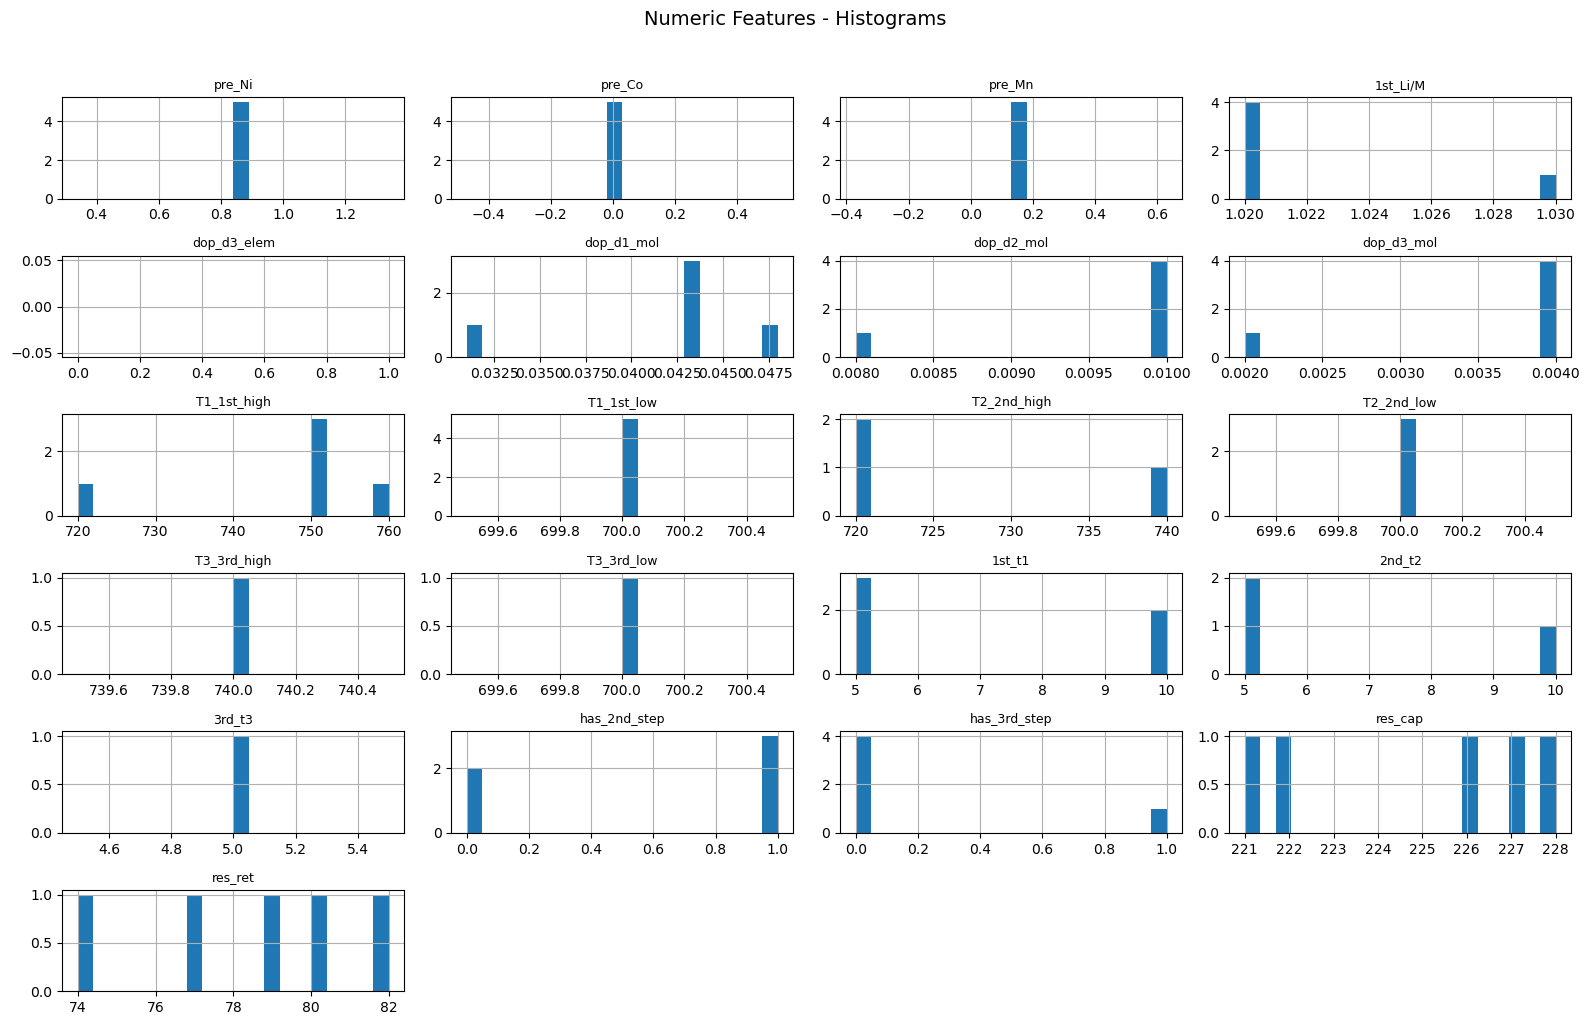

In [57]:
# -----------------------------
# 3. 숫자형 변수 히스토그램
# -----------------------------
plt.figure(figsize=(16, 10))
n_num = len(numeric_cols)
n_cols = 4
n_rows = int(np.ceil(n_num / n_cols))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    tidy_df[col].hist(bins=20)
    plt.title(col, fontsize=9)
    plt.tight_layout()

plt.suptitle("Numeric Features - Histograms", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()
# plt.savefig("eda_histograms.png", dpi=200, bbox_inches="tight")


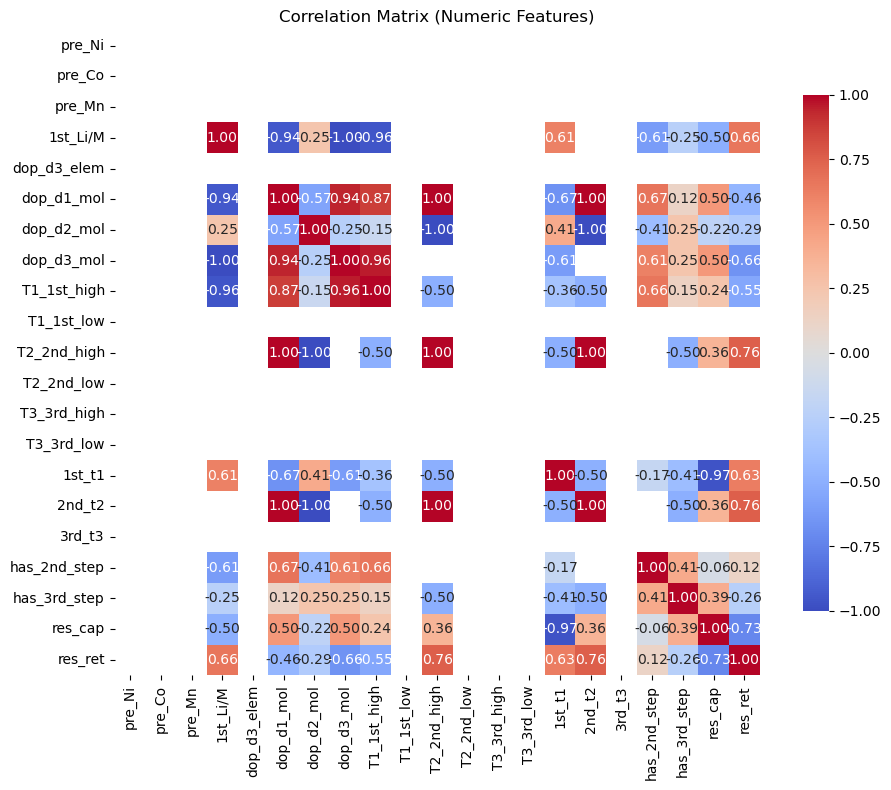

In [59]:
# -----------------------------
# 5. 숫자형 상관행렬 Heatmap
# -----------------------------
if len(numeric_cols) > 1:
    corr = tidy_df[numeric_cols].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True,
                cbar_kws={"shrink": 0.8})
    plt.title("Correlation Matrix (Numeric Features)")
    plt.tight_layout()
    plt.show()
    # plt.savefig("eda_corr_heatmap.png", dpi=200, bbox_inches="tight")



3) 결과 vs 주요 변수 Scatter Plot

[Scatter Plot] 타겟 변수: res_cap


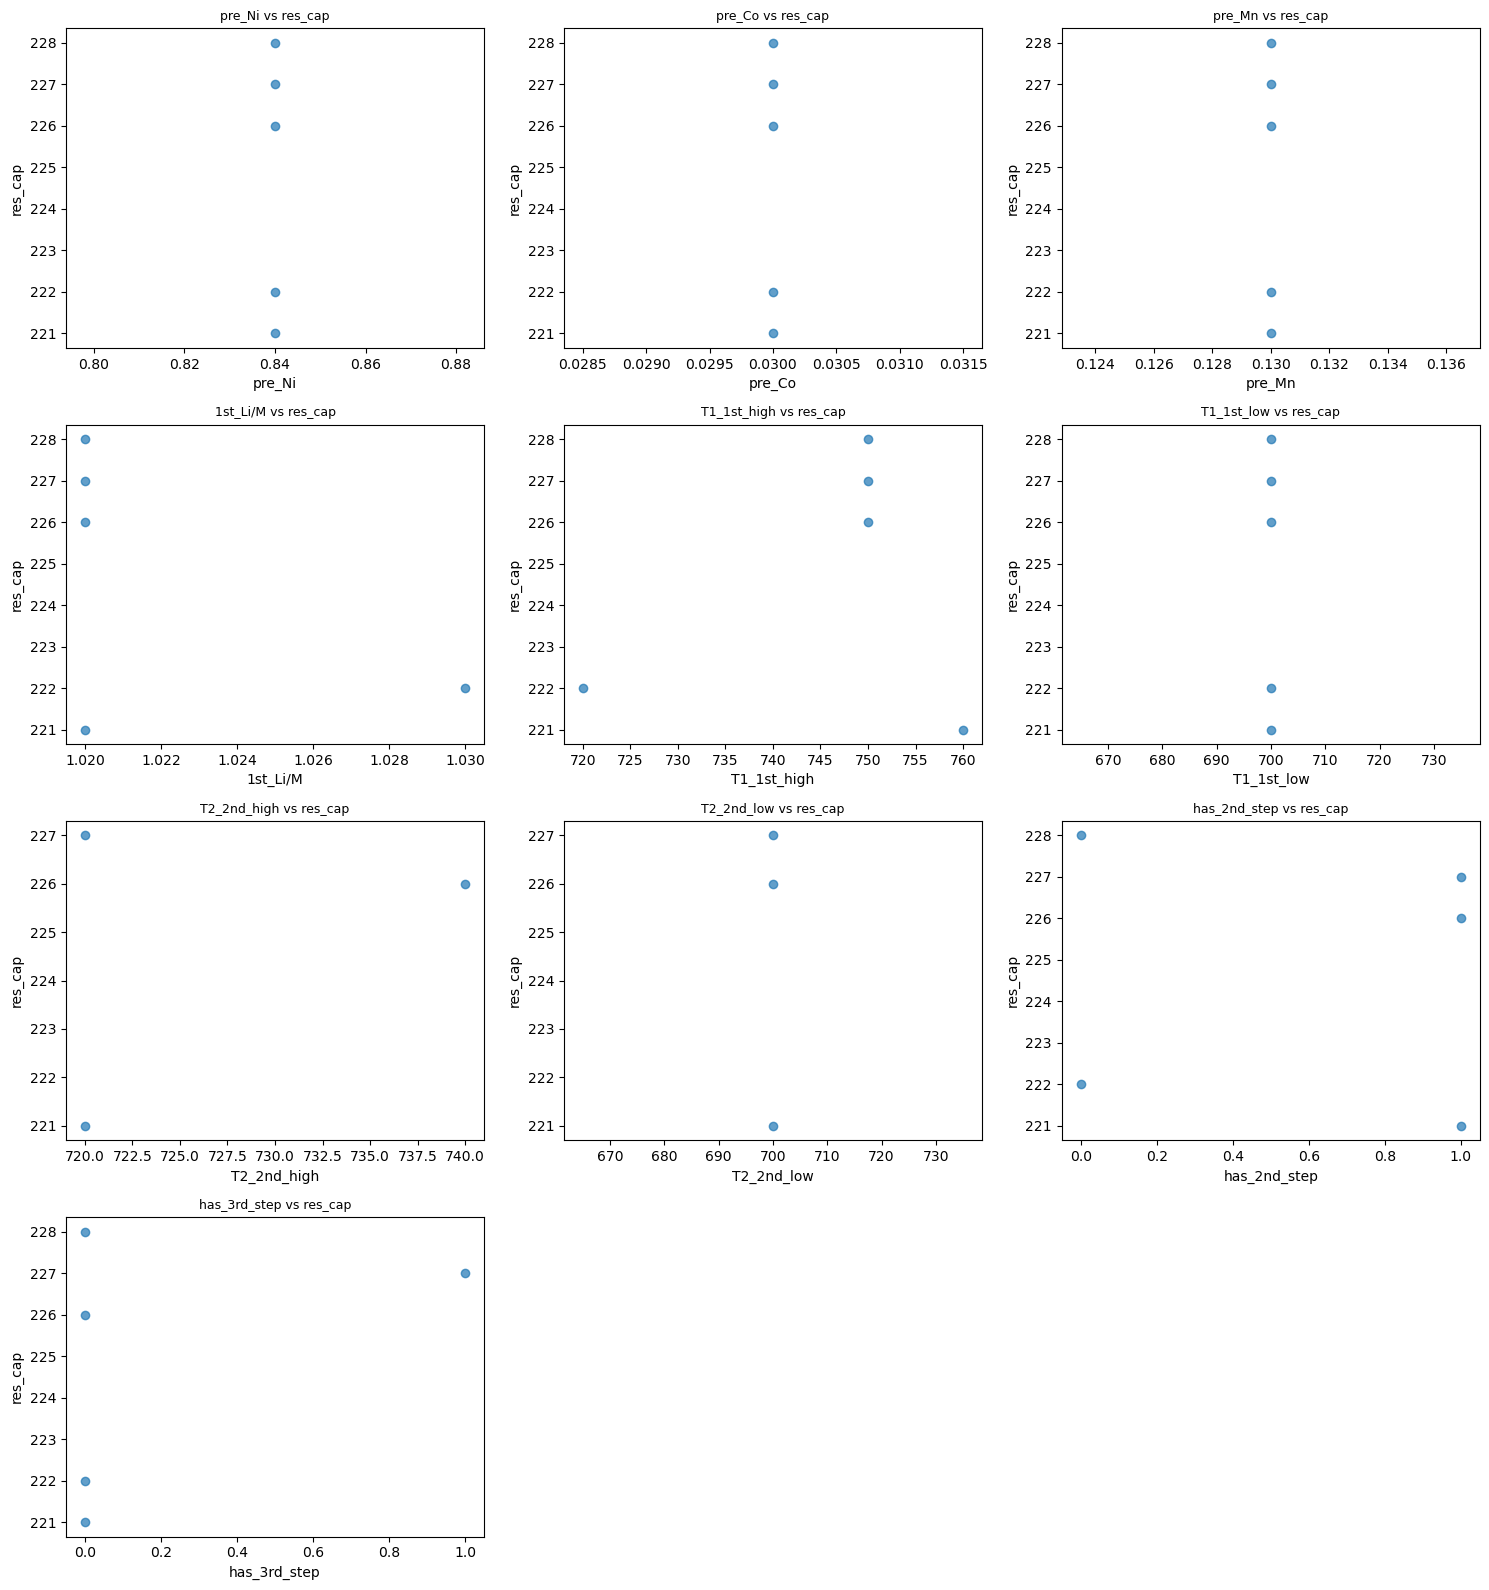


[Scatter Plot] 타겟 변수: res_ret


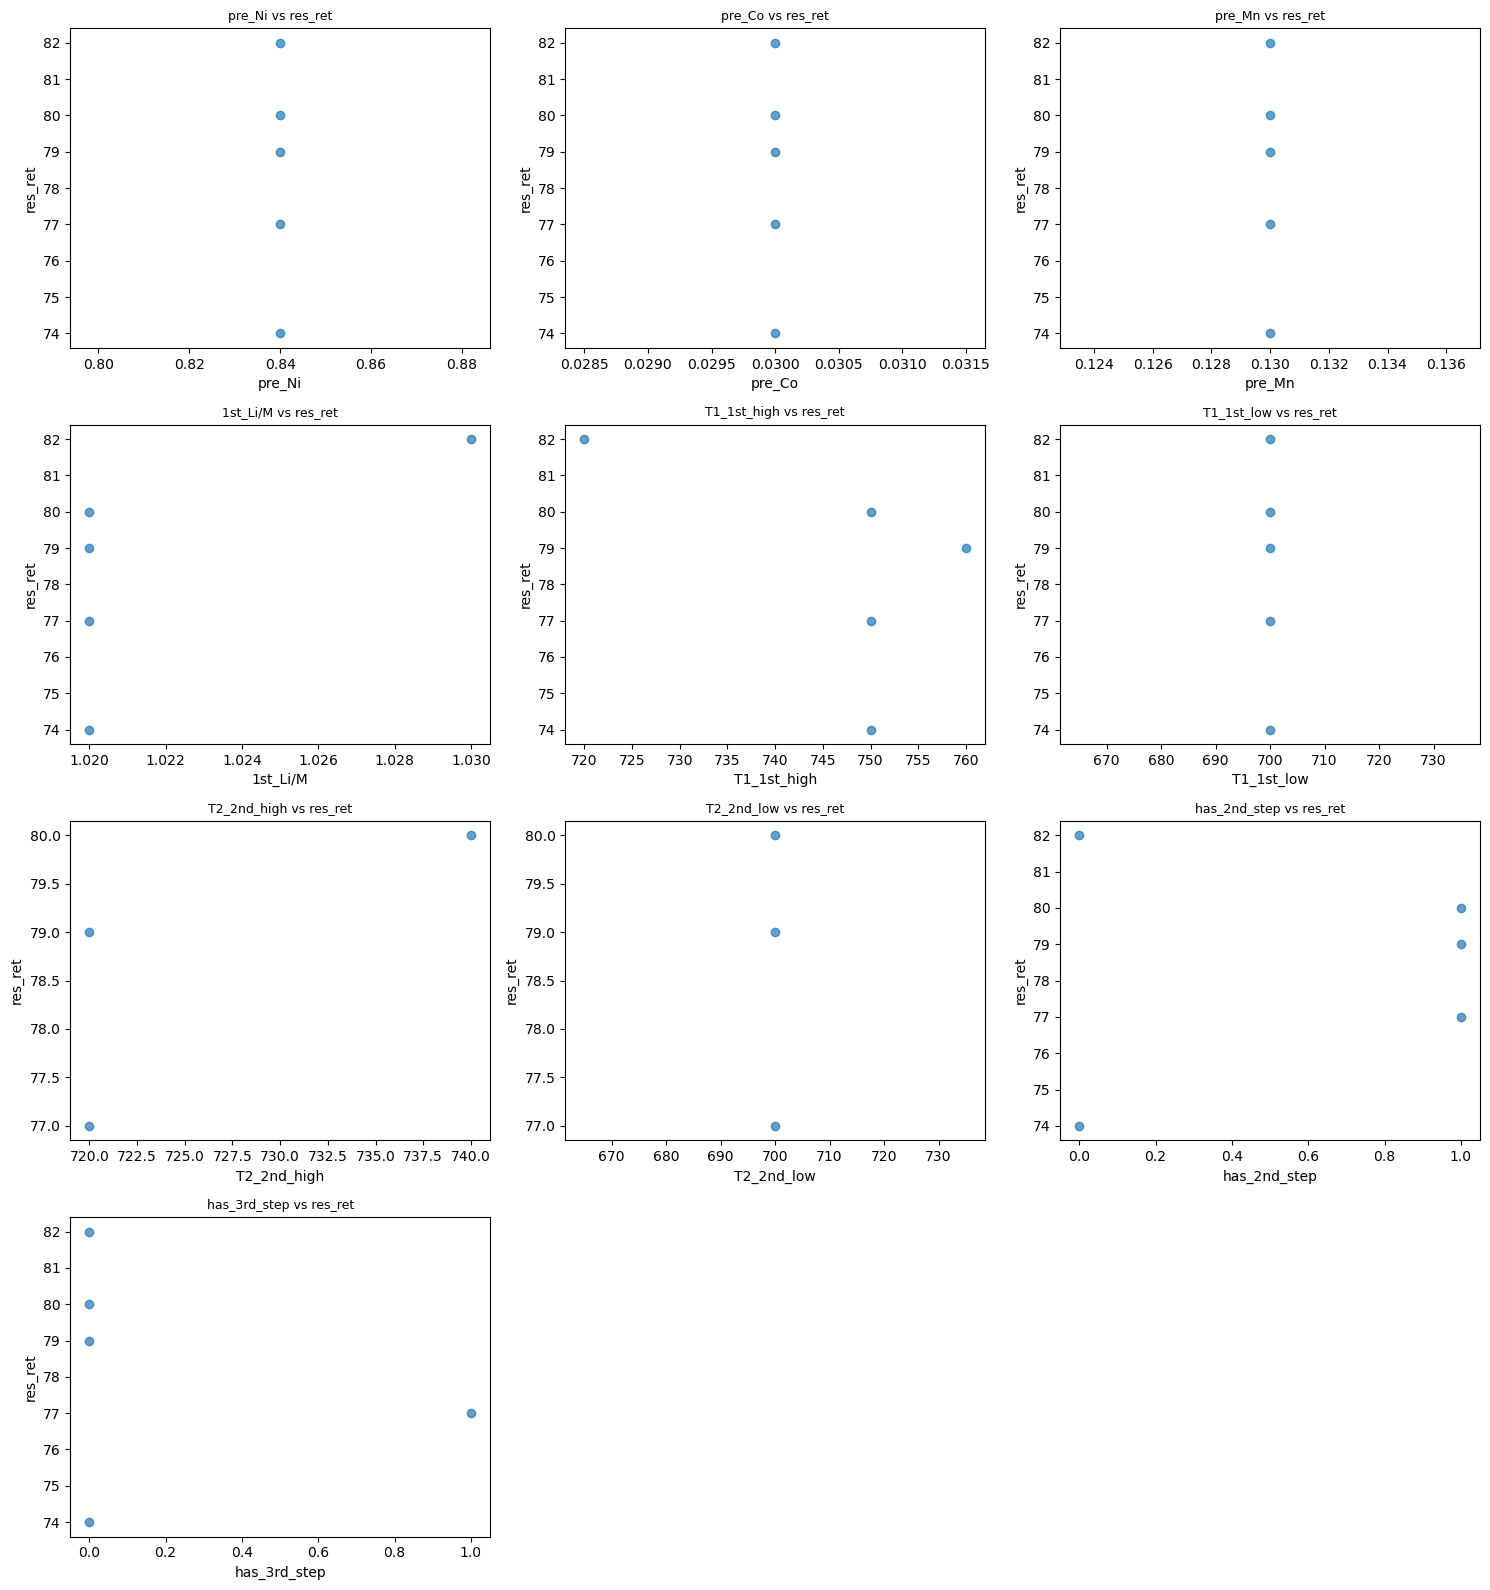

In [66]:

# ------------------------------------------------------------------
# 3. 결과 vs 주요 변수 Scatter Plot
#    - 결과: 용량, 유지율
#    - 설명 변수: 온도, 도핑량, Li/M, 공정 indicator 등 대표 변수들
# ------------------------------------------------------------------
def plot_scatter_vs_targets(tidy_df):
    # 결과(타겟) 컬럼 자동 탐색
    target_cols = [c for c in tidy_df.columns if c.startswith("res_")]
    if not target_cols:
        print("결과(타겟) 컬럼(예: '결과_방전용량', '결과_유지율')이 없습니다.")
        return

    # 대표 feature 후보 목록 (있으면 쓰고, 없으면 자동으로 일부 숫자형 선택)
    candidate_features = [
        "pre_Ni",
        "pre_Co",
        "pre_Mn",
        "1st_Li/M",
        "pre_d1_mol",
        "pre_d2_mol",
        "pre_d3_mol",
        "T1_1st_high",
        "T1_1st_low",
        "T2_2nd_high",
        "T2_2nd_low",
        "has_2nd_step",
        "has_3rd_step",
    ]

    features = [c for c in candidate_features if c in tidy_df.columns]

    # 만약 위에서 고른 대표 feature가 너무 적으면,
    # 숫자형 컬럼에서 일부를 자동으로 추가
    if len(features) < 3:
        numeric_cols = tidy_df.select_dtypes(include=[np.number]).columns.tolist()
        # 결과 컬럼 제외
        numeric_cols = [c for c in numeric_cols if c not in target_cols]
        # 앞에서 몇 개만 샘플로 사용
        extra = numeric_cols[:5]
        features = list(dict.fromkeys(features + extra))  # 중복 제거

    if not features:
        print("Scatter plot을 그릴 수 있는 숫자형 설명 변수가 없습니다.")
        return

    # 각 결과 변수별로, 주요 feature와 scatter plot 그리기
    for target in target_cols:
        print(f"\n[Scatter Plot] 타겟 변수: {target}")
        n_feat = len(features)
        n_cols = 3
        n_rows = int(np.ceil(n_feat / n_cols))

        plt.figure(figsize=(5 * n_cols, 4 * n_rows))

        for i, feat in enumerate(features, 1):
            plt.subplot(n_rows, n_cols, i)
            plt.scatter(tidy_df[feat], tidy_df[target], alpha=0.7)
            plt.xlabel(feat)
            plt.ylabel(target)
            plt.title(f"{feat} vs {target}", fontsize=9)

        plt.tight_layout()
        plt.show()

print("3) 결과 vs 주요 변수 Scatter Plot")
plot_scatter_vs_targets(tidy_df)

['pre_Ni', 'pre_Co', 'pre_Mn', '1st_Li/M', 'dop_d1_elem', 'dop_d2_elem', 'dop_d3_elem', 'dop_d1_mol', 'dop_d2_mol', 'dop_d3_mol', 'T1_1st_high', 'T1_1st_low', 'T2_2nd_high', 'T2_2nd_low', 'T3_3rd_high', 'T3_3rd_low', '1st_t1', '2nd_t2', '3rd_t3', 'has_2nd_step', 'has_3rd_step', 'res_cap', 'res_ret']
=== 데이터 기본 정보 ===
shape: (5, 23)
columns: ['pre_Ni', 'pre_Co', 'pre_Mn', '1st_Li/M', 'dop_d1_elem', 'dop_d2_elem', 'dop_d3_elem', 'dop_d1_mol', 'dop_d2_mol', 'dop_d3_mol', 'T1_1st_high', 'T1_1st_low', 'T2_2nd_high', 'T2_2nd_low', 'T3_3rd_high', 'T3_3rd_low', '1st_t1', '2nd_t2', '3rd_t3', 'has_2nd_step', 'has_3rd_step', 'res_cap', 'res_ret']


[1] 숫자형 변수 vs 결과 상관관계 Top 후보
    target      feature      corr  abs_corr
0  res_cap       1st_t1 -0.967247  0.967247
1  res_cap      res_ret -0.726477  0.726477
2  res_cap   dop_d1_mol  0.503858  0.503858
3  res_cap     1st_Li/M -0.502571  0.502571
4  res_cap   dop_d3_mol  0.502571  0.502571
5  res_ret  T2_2nd_high  0.755929  0.755929
6  res_ret       

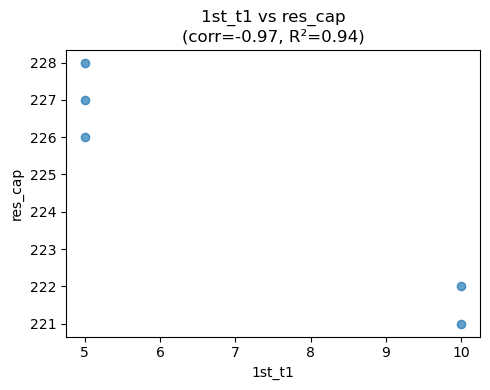

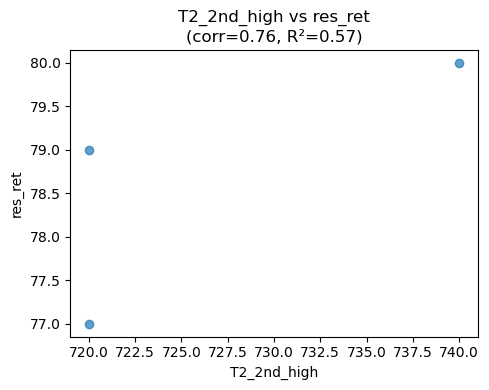

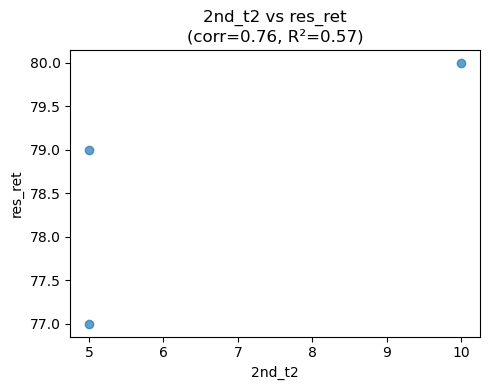

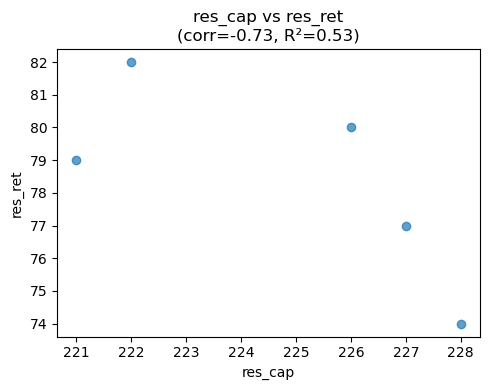

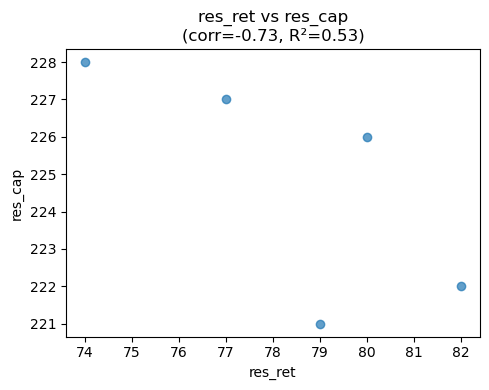

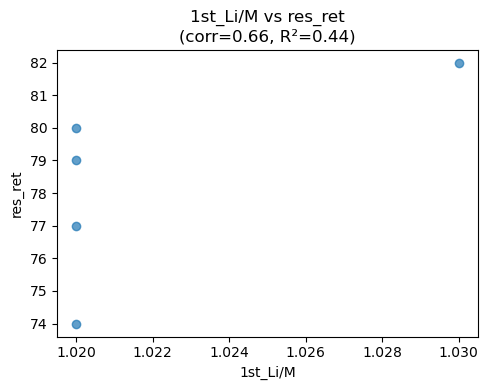

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# (전제) 이미 정의한 함수
# from your_module import load_ncm_excel_to_tidy

def load_tidy():
    tidy_df = load_ncm_excel_to_tidy("ncm_test.xlsx")
    tidy_df = tidy_df.dropna(how="all").reset_index(drop=True)
    return tidy_df


# 1) 숫자형 변수 vs 타겟: 상관관계 상위 관계 찾기
def find_top_numeric_relations(tidy_df, target_cols=None, top_k=5, min_abs_corr=0.3):
    numeric_cols = tidy_df.select_dtypes(include=[np.number]).columns.tolist()
    
    if target_cols is None:
        target_cols = [c for c in tidy_df.columns if c.startswith("res_")]
    target_cols = [c for c in target_cols if c in numeric_cols]

    results = []

    for target in target_cols:
        # 타겟을 제외한 숫자형 피처들
        cand_feats = [c for c in numeric_cols if c != target]

        corr_series = tidy_df[cand_feats + [target]].corr()[target].drop(target)
        corr_df = corr_series.to_frame("corr").reset_index().rename(columns={"index": "feature"})
        corr_df["abs_corr"] = corr_df["corr"].abs()

        # threshold/filter
        corr_df = corr_df.sort_values("abs_corr", ascending=False)
        corr_df = corr_df[corr_df["abs_corr"] >= min_abs_corr].head(top_k)

        corr_df.insert(0, "target", target)
        results.append(corr_df)

    if results:
        all_relations = pd.concat(results, ignore_index=True)
    else:
        all_relations = pd.DataFrame(columns=["target", "feature", "corr", "abs_corr"])

    return all_relations


# 2) 상위 관계들에 대해 간단한 선형 모델 맞추고 R^2 계산
def compute_linear_r2_for_relations(tidy_df, relations_df):
    rows = []
    for _, row in relations_df.iterrows():
        target = row["target"]
        feat = row["feature"]

        sub = tidy_df[[feat, target]].dropna()
        if len(sub) < 3:
            continue

        X = sub[[feat]].values
        y = sub[target].values

        model = LinearRegression()
        model.fit(X, y)
        r2 = model.score(X, y)

        rows.append({
            "target": target,
            "feature": feat,
            "corr": row["corr"],
            "abs_corr": row["abs_corr"],
            "r2_linear": r2,
            "n_samples": len(sub),
        })

    if rows:
        return pd.DataFrame(rows)
    else:
        return pd.DataFrame(columns=["target", "feature", "corr", "abs_corr", "r2_linear", "n_samples"])


# 3) 범주형 변수 vs 타겟: 그룹별 평균 차이로 “영향 큰 후보” 찾기
def find_categorical_effects(tidy_df, target_cols=None, min_diff_ratio=0.05, max_categories=10):
    """
    min_diff_ratio: (최대평균-최소평균) / 전체 평균 이 이 값 이상이면 '의미 있는 차이'로 본다.
    """
    cat_cols = tidy_df.select_dtypes(include=["object", "category"]).columns.tolist()
    if target_cols is None:
        target_cols = [c for c in tidy_df.columns if c.startswith("res_")]

    rows = []
    for target in target_cols:
        if target not in tidy_df.columns:
            continue

        overall_mean = tidy_df[target].mean()
        if pd.isna(overall_mean):
            continue

        for cat in cat_cols:
            n_unique = tidy_df[cat].nunique(dropna=True)
            if n_unique < 2 or n_unique > max_categories:
                continue  # 카테고리가 너무 적거나 많으면 패스

            grp = tidy_df.groupby(cat)[target].mean().dropna()
            if len(grp) < 2:
                continue

            diff = grp.max() - grp.min()
            diff_ratio = diff / overall_mean if overall_mean != 0 else np.nan

            if diff_ratio >= min_diff_ratio:
                rows.append({
                    "target": target,
                    "feature": cat,
                    "n_categories": n_unique,
                    "overall_mean": overall_mean,
                    "min_mean": grp.min(),
                    "max_mean": grp.max(),
                    "diff": diff,
                    "diff_ratio": diff_ratio,
                })

    if rows:
        return pd.DataFrame(rows).sort_values("diff_ratio", ascending=False)
    else:
        return pd.DataFrame(columns=[
            "target", "feature", "n_categories", "overall_mean",
            "min_mean", "max_mean", "diff", "diff_ratio"
        ])


# 4) 요약 + 간단한 시각화까지 포함한 “자동 인사이트 추출” 함수
def run_insight_extraction():
    tidy_df = load_tidy()

    print("=== 데이터 기본 정보 ===")
    print("shape:", tidy_df.shape)
    print("columns:", tidy_df.columns.tolist())
    print()

    # (1) 숫자형 변수 vs 결과: 상관관계 상위 관계
    print("\n[1] 숫자형 변수 vs 결과 상관관계 Top 후보")
    num_rel = find_top_numeric_relations(tidy_df, top_k=5, min_abs_corr=0.3)
    if len(num_rel) == 0:
        print("유의미한 상관관계(기준 이상 abs(corr))가 없습니다.")
    else:
        print(num_rel)

    # (2) 위 관계들에 대해 R^2까지 계산
    print("\n[2] 위 관계들에 대한 선형 적합도(R^2)")
    num_rel_r2 = compute_linear_r2_for_relations(tidy_df, num_rel)
    if len(num_rel_r2) == 0:
        print("R^2를 계산할 수 있는 관계가 없습니다.")
    else:
        print(num_rel_r2.sort_values("r2_linear", ascending=False))

    # (3) 범주형 변수(도핑 원소 등)의 영향도
    print("\n[3] 범주형 변수(도핑 원소 등)가 결과에 미치는 영향 후보")
    cat_eff = find_categorical_effects(tidy_df, min_diff_ratio=0.05, max_categories=10)
    if len(cat_eff) == 0:
        print("유의미한 평균 차이를 보이는 범주형 변수 후보가 없습니다.")
    else:
        print(cat_eff)

    # (4) 관심 있는 상위 몇 개 관계는 자동으로 scatter plot까지
    #     (숫자형 feature vs target만)
    print("\n[4] 상위 숫자형 관계 몇 개는 scatter plot으로 시각화")
    top_show = num_rel_r2.sort_values("r2_linear", ascending=False).head(6)
    for _, row in top_show.iterrows():
        feat = row["feature"]
        target = row["target"]
        plt.figure(figsize=(5, 4))
        plt.scatter(tidy_df[feat], tidy_df[target], alpha=0.7)
        plt.xlabel(feat)
        plt.ylabel(target)
        plt.title(f"{feat} vs {target}\n(corr={row['corr']:.2f}, R²={row['r2_linear']:.2f})")
        plt.tight_layout()
        plt.show()


if __name__ == "__main__":
    run_insight_extraction()


In [69]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# ---------------------------------------------------
# 0. tidy 데이터 로드 (이미 정의한 함수 사용)
# ---------------------------------------------------

def load_tidy():
    # 사용자가 작성한 함수라고 가정
    tidy_df = load_ncm_excel_to_tidy("ncm_test.xlsx")
    tidy_df = tidy_df.dropna(how="all").reset_index(drop=True)
    return tidy_df

tidy_df = load_tidy()

print("Shape:", tidy_df.shape)
print("Columns:", tidy_df.columns.tolist())

# ---------------------------------------------------
# 1. Feature / Target 정의
# ---------------------------------------------------

# 타겟: 방전용량 (유지율로 바꾸려면 여기만 교체)
target_col = "res_cap"
assert target_col in tidy_df.columns, f"{target_col} 컬럼이 없습니다."

y = tidy_df[target_col]

# 후보 feature들 중에서 사용할 컬럼들 정의
numeric_features = [
    col for col in [
        "pre_Ni",
        "pre_Co",
        "pre_Mn",
        "1st_Li/M",
        "1st_t1",
        "2nd_t2",
        "3rd_t3",
        "dop_d1_mol",
        "dop_d2_mol",
        "dop_d3_mol",
        "T1_1st_high",
        "T1_1st_low",
        "T2_2nd_high",
        "T2_2nd_low",
        "T3_3rd_high",
        "T3_3rd_low",
        "has_2nd_step",
        "has_3rd_step",
    ] if col in tidy_df.columns
]

categorical_features = [
    col for col in [
        "dop_d1_elem",
        "dop_d2_elem",
        "dop_d3_elem",
    ] if col in tidy_df.columns
]

X = tidy_df[numeric_features + categorical_features]

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

# ---------------------------------------------------
# 2. Train / Test split
# ---------------------------------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# ---------------------------------------------------
# 3. 전처리 파이프라인 정의
# ---------------------------------------------------

# 숫자형: 결측치는 median으로 채우고 그대로 사용
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

# 범주형: 결측치는 "missing"으로 채우고 one-hot encoding
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

# ColumnTransformer로 합치기
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# ---------------------------------------------------
# 4. GBR 모델 파이프라인 구성
# ---------------------------------------------------

gbr = GradientBoostingRegressor(random_state=42)

model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("gbr", gbr),
])

# ---------------------------------------------------
# 5. 기본 학습 & 평가
# ---------------------------------------------------

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"[Baseline GBR] RMSE: {rmse:.3f}, R²: {r2:.3f}")

# ---------------------------------------------------
# 6. 간단한 Hyperparameter Tuning (옵션)
# ---------------------------------------------------
# 데이터 양이 많지 않으면 그리 aggressively 튜닝할 필요는 없고,
# 적당한 범위에서만 시도해보면 됨.

param_grid = {
    "gbr__n_estimators": [100, 200],
    "gbr__learning_rate": [0.05, 0.1, 0.2],
    "gbr__max_depth": [2, 3, 4],
    "gbr__subsample": [0.8, 1.0],
}

grid_search = GridSearchCV(
    model,
    param_grid,
    cv=3,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
)

grid_search.fit(X_train, y_train)

print("\n[GridSearchCV] Best params:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_

y_pred_best = best_model.predict(X_test)
rmse_best = mean_squared_error(y_test, y_pred_best, squared=False)
r2_best = r2_score(y_test, y_pred_best)

print(f"[Best GBR] RMSE: {rmse_best:.3f}, R²: {r2_best:.3f}")


['pre_Ni', 'pre_Co', 'pre_Mn', '1st_Li/M', 'dop_d1_elem', 'dop_d2_elem', 'dop_d3_elem', 'dop_d1_mol', 'dop_d2_mol', 'dop_d3_mol', 'T1_1st_high', 'T1_1st_low', 'T2_2nd_high', 'T2_2nd_low', 'T3_3rd_high', 'T3_3rd_low', '1st_t1', '2nd_t2', '3rd_t3', 'has_2nd_step', 'has_3rd_step', 'res_cap', 'res_ret']
Shape: (5, 23)
Columns: ['pre_Ni', 'pre_Co', 'pre_Mn', '1st_Li/M', 'dop_d1_elem', 'dop_d2_elem', 'dop_d3_elem', 'dop_d1_mol', 'dop_d2_mol', 'dop_d3_mol', 'T1_1st_high', 'T1_1st_low', 'T2_2nd_high', 'T2_2nd_low', 'T3_3rd_high', 'T3_3rd_low', '1st_t1', '2nd_t2', '3rd_t3', 'has_2nd_step', 'has_3rd_step', 'res_cap', 'res_ret']
Numeric features: ['pre_Ni', 'pre_Co', 'pre_Mn', '1st_Li/M', '1st_t1', '2nd_t2', '3rd_t3', 'dop_d1_mol', 'dop_d2_mol', 'dop_d3_mol', 'T1_1st_high', 'T1_1st_low', 'T2_2nd_high', 'T2_2nd_low', 'T3_3rd_high', 'T3_3rd_low', 'has_2nd_step', 'has_3rd_step']
Categorical features: ['dop_d1_elem', 'dop_d2_elem', 'dop_d3_elem']
[Baseline GBR] RMSE: 4.168, R²: -1.780

[GridSearchCV]